In [3]:
import nbimporter
import numpy as np
from math import inf
import numpy.random as alea
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import pylab
from sklearn import linear_model
import sklearn.datasets as sk_data
from procedure_MOM import procedure_MOM as PM
from Creation_de_base_aléatoire import base as base

Importing Jupyter notebook from procedure_MOM.ipynb
Importing Jupyter notebook from Creation_de_base_aléatoire.ipynb


Explanation of LARS-Lasso:

We want to solve : $$ arg\min_{t}{\frac{1}{2}\|Y-Xt\|_{2}^2+𝛌\|t\|_{1}}$$

Let f=Xt

Step k:

$$ \forall j \in (1,p) \quad x_{j} $$ the j-th column of X

The active set at step k is  $$ A_k=\{x_{j_1},...,x_{j_k}\} $$
The correlation of variable j at step k+1 with the residual is : $$ c_{j}^{k+1} = <x_{j}|y-f_{k}>  \quad and \quad C^{k+1}=\max_{j \in A_{k}^c}{|c_{j}^{k+1}|}$$

So : $$ A_{k+1}=A_k \cup \{j_{k+1}=arg\max_{j \in A_{k}^c}{|c_{j}^{k+1}|}\} \quad \text{and let} \quad X_{A_{k+1}}=[..s_{j}x_j..]_{j \in A_{k+1}} \ \text{with} \ s_j=sign(c_{j}^{k+1}) $$

We want to approximate:
$$ f_{k+1}=f_{k}+𝛄_{k+1}u_{k+1}$$
With $$u_{k+1}=M_{k+1}X_{A_{k+1}}(X_{A_{k+1}}^tX_{A_{k+1}})^{-1}1_{k+1} \ \text{the equiangular vector to} \ X_{A_{k+1}} \ \text{where} \  M_{k+1}=(1_{k+1}^t(X_{A_{k+1}}^tX_{A_{k+1}})^{-1}1_{k+1})^{-0.5}$$

At step k+2 we want: $$ |C^{k+2}|=|c_{j_{k+1}}^{k+2}| = |<x_{j_{k+1}}|y-f_{k+1}>| \quad \text{by construction} <x_{j}|y-f_{k+1}>=<x_{j'}|y-𝜇_{k+1}> \ \forall j,j' \in A_{k+1})$$

Let  $ j_{k+2}=arg\max_{j \in A_{k+1}^c}{|c_{j}^{k+2}|}$, we have :

$$ C^{k+2}=|<x_{j_{k+2}}|y-f_{k+1}>|=|c_{j_{k+2}}^{k+1}-g_{k+1}<x_{j_{k+2}}|u_{k+1}>|$$

$$\text{and}	 |<x_{j_{k+1}}|y-f_{k+1}>|=|c^{k+1}-g_{k+1}<x_{j_{k+1}}|u_{k+1}>|=|c^{k+1}- g_{k+1}M_{k+1}|$$

$$ \Rightarrow	g_{k+1} \in \{\frac{c^{k+1}-c_{j_{k+2}}^{k+1}}{M_{k+1}-<x_{j_{k+2}}|u_{k+1}>},\frac{c^{k+1}+c_{j_{k+2}}^{k+1}}{M_{k+1}+<x_{j_{k+2}}|u_{k+1}>}\} $$ 

 
We want $C^{k+2}$ maximal but $C^{k+2}=C^{k+1}-g_{k+1}M_{k+1}$ so :


$$ g_{k+1} \in \min_{j \in A_{k+1}^c}^+\{\frac{c^{k+1}-c_{j}^{k+1}}{M_{k+1}-<x_{j}|u_{k+1}>},\frac{c^{k+1}+c_{j}^{k+1}}{M_{k+1}+<x_{j}|u_{k+1}>}\} $$

### Algorithm

In [69]:
def lars_lasso(X, Y):
    
    n , p = np.shape(X)
    mu = np.zeros((n,1))
    act_set = []
    inact_set = list(range(p))
    beta = np.zeros((p+1,p))
    corr = np.zeros((p+1,p))
    k = 0
    etape = 0
    bcl = True
    
    while k < p :
        
        print(k)
        c = X.T * (Y - mu)
        
        #Case where the x-axis has not be crossed
        if bcl :     
            
            jmax = inact_set[np.argmax(abs(c[inact_set]))]
            C = abs(c[jmax][0])
            act_set.append(jmax)
            inact_set.remove(jmax)
            
        print("Correlation à l'étape" , etape , " : " , c)
        corr[etape] = c.T
        print("A=" , act_set , "A_complementaire=" , inact_set)
        
        #calcul of the equiangular vector
        s = np.sign(c[act_set])
        XA = np.multiply(X.T[act_set],s).T
        GA1 = np.linalg.solve(XA.T * XA,np.identity(k + 1))
        AA = 1 / np.sqrt(float(np.sum(GA1)))
        w = AA * np.dot(GA1,np.ones((len(act_set),1)))
        u = XA * w  
        
        #calcul of 𝛄_tilde
        d = np.multiply(w,s)
        gamma_tilde = (-beta[etape,act_set]) / d.reshape((1,-1))
        gamma_tilde , j_tilde = PM.min_pos(gamma_tilde) 
        j_tilde = act_set[j_tilde]
        print("𝛄_tilde=" , gamma_tilde)
        
        #calcul of gamma
        if k == (p - 1) :  #Final case
            
            gamma = float(C / AA)
            
        else :  
            
            a = X.T * u
            print("a=" , a , "AA=" , AA)
            
            tmp = np.concatenate((((C + c[inact_set]) / (AA + a[inact_set])).reshape(-1)[0],((C - c[inact_set]) / (AA - a[inact_set])).reshape(-1)[0]),axis=1)
            gamma , jmax = PM.min_pos(tmp)
            
            if jmax >= len(inact_set) :
                jmax -= len(inact_set)
            jmax = inact_set[jmax]
            
            print("tmp=" , tmp , "𝛾_chapeau=" , gamma , "jmax=" , jmax)
            
        #If a coefficient is supposed to cut the x-axis, we put it to 0, pull it of the active set and recompute the step.
        if gamma_tilde <= gamma :
            
            print("BOUCLE LASSO")
            mu = mu + gamma_tilde * u
            beta[etape+1,act_set] = beta[etape,act_set] + gamma_tilde * d.T
            C = C - gamma_tilde * AA
            beta = np.concatenate((beta,np.zeros((2,p))))
            corr = np.concatenate((corr,np.zeros((1,p))))
            inact_set.append(j_tilde)
            act_set.remove(j_tilde)
            etape += 1
            k -= 1
            bcl = False
            
        else :
            
            mu = mu + gamma * u
            beta[etape+1,act_set] = beta[etape,act_set] + gamma * d.T
            C = C - gamma * AA
            k += 1
            etape += 1
            bcl = True
            
        print("C=" , C)
        
    return beta , corr

### Test on diabete data_base.

In [70]:
D=sk_data.load_diabetes()
X=D.data
Y=D.target.reshape((442,1))
X,Y=np.matrix(X),np.matrix(Y)
B,C=lars_lasso(X,Y)

0
Correlation à l'étape 0  :  [[ 304.18307453]
 [  69.71535568]
 [ 949.43526038]
 [ 714.7416437 ]
 [ 343.25445189]
 [ 281.78459335]
 [-639.14527932]
 [ 696.88303009]
 [ 916.13872282]
 [ 619.22282068]]
A= [2] A_complementaire= [0, 1, 3, 4, 5, 6, 7, 8, 9]
𝛄_tilde= inf
a= [[ 0.18508467]
 [ 0.0881614 ]
 [ 1.        ]
 [ 0.39541532]
 [ 0.24977742]
 [ 0.26116991]
 [-0.36681098]
 [ 0.4138066 ]
 [ 0.44615865]
 [ 0.38867999]] AA= 1.0000000000000941
tmp= [[1057.83018777  936.58037951 1192.60329083 1034.33594637  976.25216304
   490.0432106  1164.45791691 1290.02027921 1129.60371573  791.80272974
   964.77589758  388.18981839  808.00128664  903.65928123 1162.25327774
   430.83431352   60.11926965  540.16298568]] 𝛾_chapeau= 60.119269649095855 jmax= 8
C= [[889.31599073]]
1
Correlation à l'étape 1  :  [[ 293.05591958]
 [  64.41515676]
 [ 889.31599073]
 [ 690.96956339]
 [ 328.23801572]
 [ 266.08324904]
 [-617.0928712 ]
 [ 672.00527941]
 [ 889.31599073]
 [ 595.85566332]]
A= [2, 8] A_complementaire= [0

<IPython.core.display.Javascript object>


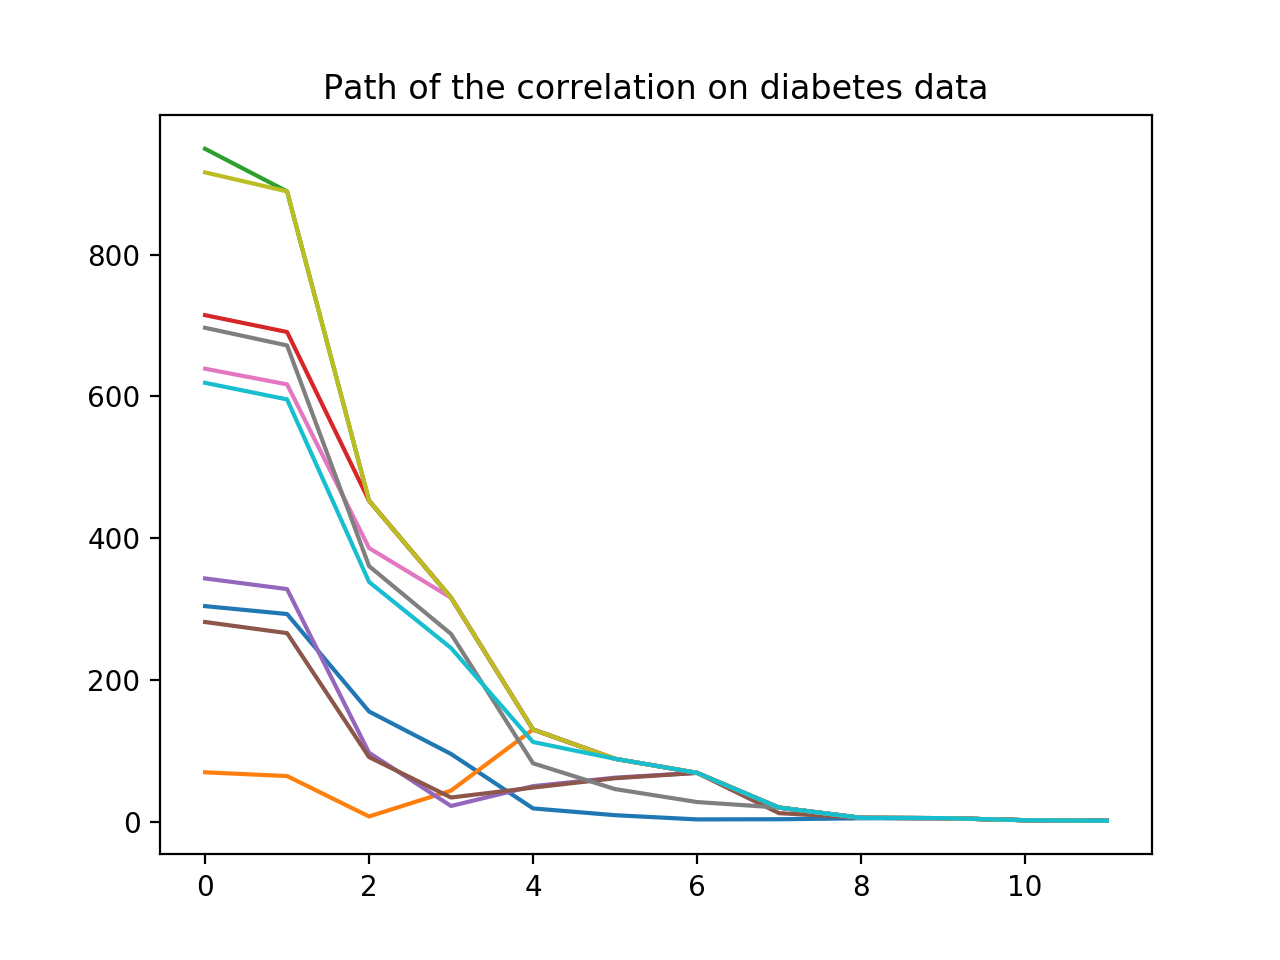

In [68]:
%matplotlib notebook
plt.plot(np.array(range(np.shape(C)[0])),abs(C))
plt.title("Path of the correlation on diabetes data")
plt.show()

<IPython.core.display.Javascript object>


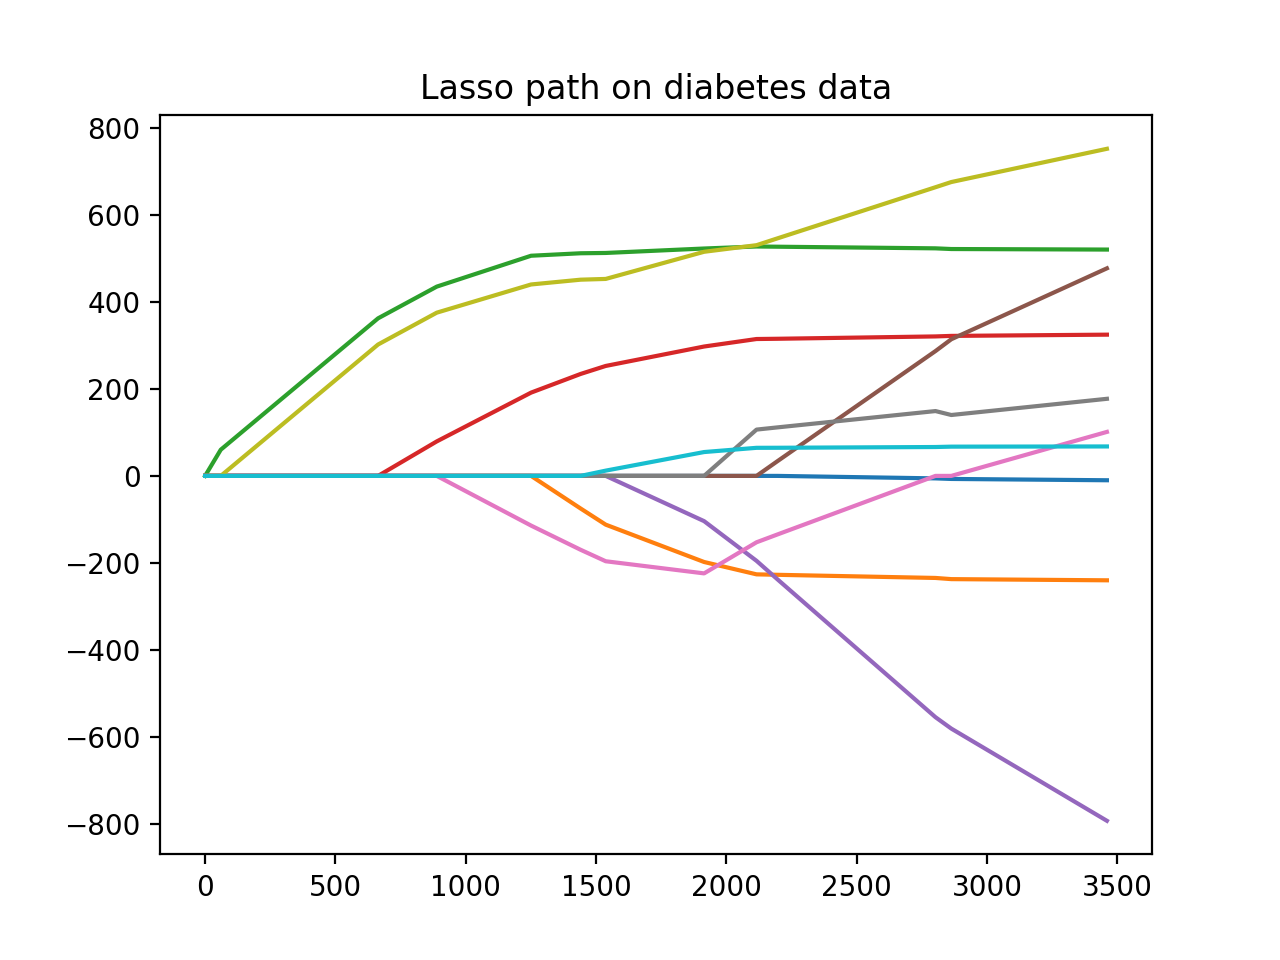

In [30]:
xx = np.sum(np.abs(B), axis=1)
%matplotlib notebook
plt.plot(xx,B)
plt.title("Lasso path on diabetes data")
plt.show()